In [24]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy as sc
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.optimize import newton
from scipy.optimize import root_scalar
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.ticker import StrMethodFormatter
from matplotlib.collections import LineCollection
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
e      = 1.6*10**(-19)             #Charge of electron
hbar   = 1.054 * 10**(-34)         #SI  Js 
hbarev = 6.59*10**(-16)            #SI  eVs
me     = 9.1 * 10**(-31)           #SI  kg
meff   = 0.035*me                  #SI  kg
#kb     = 1.38 * 10**(-23)         #SI  J/K
kbev   = 8.617 * 10**(-5)          #SI  eV/K
c      = 3*(10**8)                 #SI  m/s
omega  = 0.110                     #SI eV  interlayer hopping energy 
d      = 1.420 *10**(-10)          #SI m  C-C distance in graphene
vf     = 1.5*d*2.866/hbarev          #SI m/s, Fermi velocity for SLG  = 0.905 *10**(6)
N      = 1000                       #No. of landau leveles
N_con  = 150                        #No. of landau levels considering (should be less than or equal to N)

In [15]:
ei120  = np.cos(2*np.pi/3) + 1j*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - 1j*np.sin(2*np.pi/3)

Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[ei240, 1], [ei120, ei240]], dtype=complex)
Tqtl   = omega*np.array([[ei120, 1], [ei240, ei120]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)

In [16]:
def Hk_twist_spec(kx,ky,theta):   #8 Band hamiltonain  #gives eigenvalues only about K(or K') point of 1st layer
    
    ktheta = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d

    # Hopping vectors in k space
    
    qb      = ktheta*np.array([0, -1])
    qtr     = ktheta*np.array([np.sqrt(3)/2,0.5])
    qtl     = ktheta*np.array([-np.sqrt(3)/2,0.5])
     
    Hk      = np.array(np.zeros((8, 8)), dtype=complex)
    
    qx           = kx*np.cos(theta/2)-ky*np.sin(theta/2)   
    qy           = kx*np.sin(theta/2)+ky*np.cos(theta/2)
    qx1          = (kx+qb[0])*np.cos(theta/2)+(ky+qb[1])*np.sin(theta/2)
    qy1          = -(kx+qb[0])*np.sin(theta/2)+(ky+qb[1])*np.cos(theta/2)
    qx2          = (kx+qtr[0])*np.cos(theta/2)+(ky+qtr[1])*np.sin(theta/2)
    qy2          = -(kx+qtr[0])*np.sin(theta/2)+(ky+qtr[1])*np.cos(theta/2)
    qx3          = (kx+qtl[0])*np.cos(theta/2)+(ky+qtl[1])*np.sin(theta/2)
    qy3          = -(kx+qtl[0])*np.sin(theta/2)+(ky+qtl[1])*np.cos(theta/2)
    
    #qx      =  kx             #NOTE THAT FOR THE ANGLE <10 ROTATION CAN BE NEGLECTED
    #qy      =  ky
    #qx1     =  (kx+qb[0])
    #qy1     =  (ky+qb[1])
    #qx2     =  (kx+qtr[0])
    #qy2     =  (ky+qtr[1])
    #qx3     =  (kx+qtl[0])
    #qy3     =  (ky+qtl[1])
      
    Hk[0,1]      = -hbarev*vf*(qx+1j*qy)     
    Hk[1,0]      = -hbarev*vf*(qx-1j*qy)
    Hk[2,3]      = -hbarev*vf*(qx1+1j*qy1)
    Hk[3,2]      = -hbarev*vf*(qx1-1j*qy1)
    Hk[4,5]      = -hbarev*vf*(qx2+1j*qy2)
    Hk[5,4]      = -hbarev*vf*(qx2-1j*qy2)
    Hk[6,7]      = -hbarev*vf*(qx3+1j*qy3)
    Hk[7,6]      = -hbarev*vf*(qx3-1j*qy3)

            
    
    Hk[0:2,2:4]  = Tqb
    Hk[0:2,4:6]  = Tqtr
    Hk[0:2,6:8]  = Tqtl
    Hk[2:4,0:2]  = TqbD
    Hk[4:6,0:2]  = TqtrD
    Hk[6:8,0:2]  = TqtlD
    
    eigenvalue,featurevector=np.linalg.eigh(Hk)
    eig_vals_sorted = np.sort(eigenvalue)
    return eig_vals_sorted

def Hk_twist_spec_2B_approx(kx,ky,theta):
    
    ktheta = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d
    alpha= omega/(hbarev*vf*ktheta)
    vfn=vf*(1-3*alpha**2)/(1+6*alpha**2)    #new Renormalized fermi velocity
    
    
    Hk = np.array(np.zeros((2, 2)), dtype=complex)
    
    Hk[0,1]=hbarev*vfn*(kx+1j*ky)
    Hk[1,0]=hbarev*vfn*(kx-1j*ky)
    
    eigenvalue,featurevector=np.linalg.eigh(Hk)
    eig_vals_sorted = np.sort(eigenvalue)
    return eig_vals_sorted

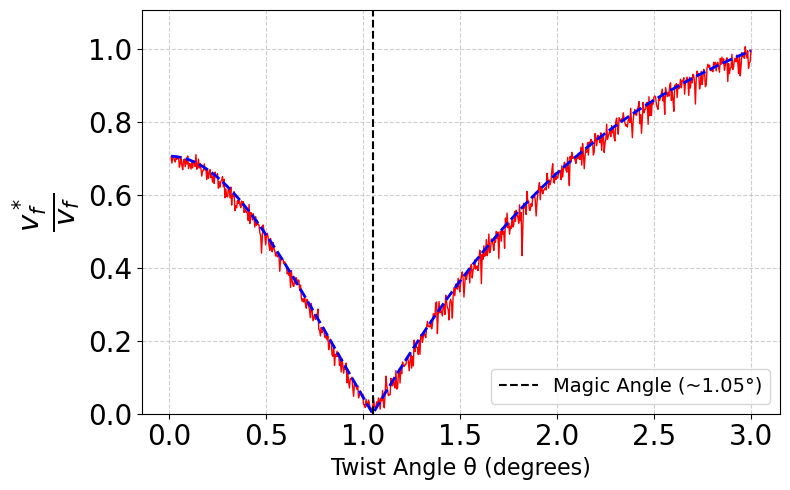

In [17]:
def compute_fermi_velocity(theta, delta_k=1e-5):

    eig_k0 = Hk_twist_spec_2B_approx(0,0,theta)
    
    idx_closest = np.argmin(np.abs(eig_k0))
    E0 = eig_k0[idx_closest]
    
    eig_kx_plus = Hk_twist_spec_2B_approx(delta_k,0,theta)
    Ekx_plus = eig_kx_plus[idx_closest]
    
    eig_ky_plus = Hk_twist_spec_2B_approx(0,delta_k,theta)
    Eky_plus = eig_ky_plus[idx_closest]

    vFx = (Ekx_plus - E0) / (delta_k*hbarev)
    vFy = (Eky_plus - E0) / (delta_k*hbarev)
    
    vF = np.sqrt(vFx**2 + vFy**2) 
    
    return vF

def compute_fermi_velocity_exact(theta, delta_k=1e-5):

    eig_k0 = Hk_twist_spec(0, 0, theta)

    idx_closest = np.argmin(np.abs(eig_k0))
    E0 = eig_k0[idx_closest]
    
    eig_kx_plus = Hk_twist_spec(delta_k, 0, theta)
    Ekx_plus = eig_kx_plus[idx_closest]

    eig_ky_plus = Hk_twist_spec(0, delta_k, theta)
    Eky_plus = eig_ky_plus[idx_closest]
    
    vFx = (Ekx_plus - E0) / (delta_k*hbarev)
    vFy = (Eky_plus - E0) / (delta_k*hbarev)
   
    vF = np.sqrt(vFx**2 + vFy**2) 
    
    return vF



theta_degrees = np.linspace(0.01, 3, 700)  
theta_radians = np.deg2rad(theta_degrees)   


vF_values_approx = np.zeros_like(theta_degrees)
vF_values_exact = np.zeros_like(theta_degrees)


for i, theta in enumerate(theta_radians):
    vF_values_approx[i] = compute_fermi_velocity(theta)/vf  # Use the function defined earlier
    vF_values_exact[i] = compute_fermi_velocity_exact(theta)/vf




plt.figure(figsize=(8, 5))
plt.plot(theta_degrees, vF_values_exact, 'r-', linewidth=1)
plt.plot(theta_degrees, vF_values_approx, 'b--', linewidth=2)
plt.xlabel('Twist Angle θ (degrees)', fontsize=16)
plt.ylabel(r'$\frac{v_f^*}{v_f}$', fontsize=30)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.1 * np.max(vF_values_exact)) 
plt.tick_params(axis='both', which='major', labelsize=20)
plt.axvline(x=1.05, color='black', linestyle='--', label='Magic Angle (~1.05°)')
plt.legend(fontsize=14)  
plt.tight_layout() 
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

In [18]:
upper=Qobj([[0,1],[0,0]])
lower=Qobj([[0,0],[1,0]])

def hk_mono_LS(N_con,B,qx,qy,pos):            
    
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    
    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    hk=E_fac*(tensor((kx+qx)+1j*(ky+qy),upper)+tensor((kx+qx)-1j*(ky+qy),lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)
    
    return eig_vals_sorted               #eigvals here is in eV

def bi_hk(N_con,B,pos):
      
    lB = np.sqrt(hbar/(e*B))
    anhi     = destroy(N_con)
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 

    
    kx=0.5*(anhi+anhi.dag())/M_fac
    ky=0.5j*(anhi-anhi.dag())/M_fac
    
    
    bi_hk= -(hbar**2/(2*meff*e))*(tensor((kx+1j*ky)**2,upper)+tensor((kx-1j*ky)**2,lower)).full()
    
    eigenvalue,featurevector=np.linalg.eigh(bi_hk)
    eig_vals_sorted = np.sort(eigenvalue)
    
    if pos:
        eig_vals_sorted = eig_vals_sorted[-N_con:]
        return np.array(eig_vals_sorted)
    
    return eig_vals_sorted               #eigvals here is in eV

def  Hk_twist_landau_spec(N,B,theta,N_con):  
    
    
    anhi     = destroy(N)
    lB = np.sqrt(hbar/(e*B))
    
    E_fac = hbarev*vf                              #SI eVm 
    M_fac = lB/np.sqrt(2)                          #SI m 
    I_n   = identity(N)
    
    sin_half = np.sin(theta/2)
    cos_half = np.cos(theta/2)
    
    
    ktheta   = 8*np.pi*sin_half/3/np.sqrt(3)/d                   #SI m^-1

    # Hopping vectors in k space
    
    qb      = ktheta*np.array([0, -1])
    qtr     = ktheta*np.array([np.sqrt(3)/2,0.5])
    qtl     = ktheta*np.array([-np.sqrt(3)/2,0.5])
    
    Hk      = np.array(np.zeros((8*N, 8*N)), dtype=complex)
    
    kx      = 0.5*(anhi+anhi.dag())/M_fac
    ky      = 0.5j*(anhi-anhi.dag())/M_fac
    
    
    qx      =  kx
    qy      =  ky
    qx1     =  (kx+qb[0])
    qy1     =  (ky+qb[1])
    qx2     =  (kx+qtr[0])
    qy2     =  (ky+qtr[1])
    qx3     =  (kx+qtl[0])
    qy3     =  (ky+qtl[1])
    
    
    H11     = -E_fac*(tensor((qx+1j*qy),upper)+tensor((qx-1j*qy),lower)).full()  
    H22     = -E_fac*(tensor((qx1+1j*qy1),upper)+tensor((qx1-1j*qy1),lower)).full()
    H33     = -E_fac*(tensor((qx2+1j*qy2),upper)+tensor((qx2-1j*qy2),lower)).full()
    H44     = -E_fac*(tensor((qx3+1j*qy3),upper)+tensor((qx3-1j*qy3),lower)).full()

   
    Hk[0:2*N,0:2*N]       = H11
    Hk[2*N:4*N,2*N:4*N]   = H22
    Hk[4*N:6*N,4*N:6*N]   = H33
    Hk[6*N:8*N,6*N:8*N]   = H44
    Hk[0:2*N,2*N:4*N]     = tensor(I_n,Qobj(Tqb)).full()
    Hk[0:2*N,4*N:6*N]     = tensor(I_n,Qobj(Tqtr)).full()
    Hk[0:2*N,6*N:8*N]     = tensor(I_n,Qobj(Tqtl)).full()
    Hk[2*N:4*N,0:2*N]     = tensor(I_n,Qobj(TqbD)).full()
    Hk[4*N:6*N,0:2*N]     = tensor(I_n,Qobj(TqtrD)).full()
    Hk[6*N:8*N,0:2*N]     = tensor(I_n,Qobj(TqtlD)).full()
    

    Hk = csr_matrix(Hk, dtype=complex)

    eigenvalues, eigenvectors = eigsh(Hk, k=2*N_con, sigma=1e-8, tol=1e-12)


    eigenvalues = np.round(eigenvalues, 6)


    eigenvalues_abs = np.abs(eigenvalues)


    eigenvalues_sort = np.sort(eigenvalues_abs)



    final_eigenvalues = eigenvalues_sort[::2]

    
    return final_eigenvalues


def Positive_landau_plot(N,B,theta,N_con):      
    
    eigvals = Hk_twist_landau_spec(N,B,theta,N_con) 
    lB = np.sqrt(hbar/(e*B))
    Pos_eigvals = eigvals[-N_con:]
    Xvals = np.arange(len(Pos_eigvals))
    Decoup_approx_eigvals = [np.sqrt(2)*hbarev*vf/lB  * np.sqrt(i / 4) for i in range(len(Xvals))]
    return Xvals, np.array(Pos_eigvals), Decoup_approx_eigvals




In [21]:
def save_landau_spectrum_over_B(N, theta, N_con, B1=1.0, rc_range=(0.3, 8.0), steps=1000, filename=None):
    rc_vals = np.linspace(rc_range[0], rc_range[1], steps)
    B_vals = B1 * rc_vals

    spectra = []  

    for B in tqdm(B_vals, desc="Computing spectra"):
        
        energies = Hk_twist_landau_spec(N, B, theta, N_con)
        #energies =bi_hk(N_con, B, True)
        
        spectra.append(energies)

    spectra_array = np.array(spectra)

    if filename is None:
        filename = f"spectrum_B_1T_N{N}_theta{np.round(np.degrees(theta),2)}_Ncon{N_con}_rc1000.npz"
        #filename = f"spectrum_B_1T_N{N}_theta{theta}_Ncon{N_con}_rc1000.npz"
    
    np.savez(filename, B_vals=B_vals, spectra=spectra_array)

    print(f"Saved spectra to {filename}")
    return filename

def save_landau_spectrum_over_theta(N, rc, N_con, B1=1.0, theta_range=(0.0001, 4.0), steps=80, filename=None):
    
    theta_vals_deg = np.linspace(theta_range[0], theta_range[1], steps)  # degrees
    theta_vals_rad = np.radians(theta_vals_deg)  
    
    B = B1 * rc 

    spectra = []

    for theta in tqdm(theta_vals_rad, desc="Computing spectra over θ"):
        energies = Hk_twist_landau_spec(N, B, theta, N_con)
        spectra.append(energies)

    spectra_array = np.array(spectra)  
    if filename is None:
        filename = f"spectrum_theta_sweep_N{N}_rc{rc}_Ncon{N_con}_steps{steps}.npz"

    np.savez(filename, theta_vals_deg=theta_vals_deg, spectra=spectra_array, rc=rc, B=B)

    print(f"Saved θ-sweep spectra to {filename}")
    return filename

# Example usage:
save_landau_spectrum_over_B(N, 1.05*np.pi/180, N_con)
save_landau_spectrum_over_theta(N, rc=1, N_con=N_con)

Computing spectra:   0%|                               | 0/1000 [00:05<?, ?it/s]


KeyboardInterrupt: 

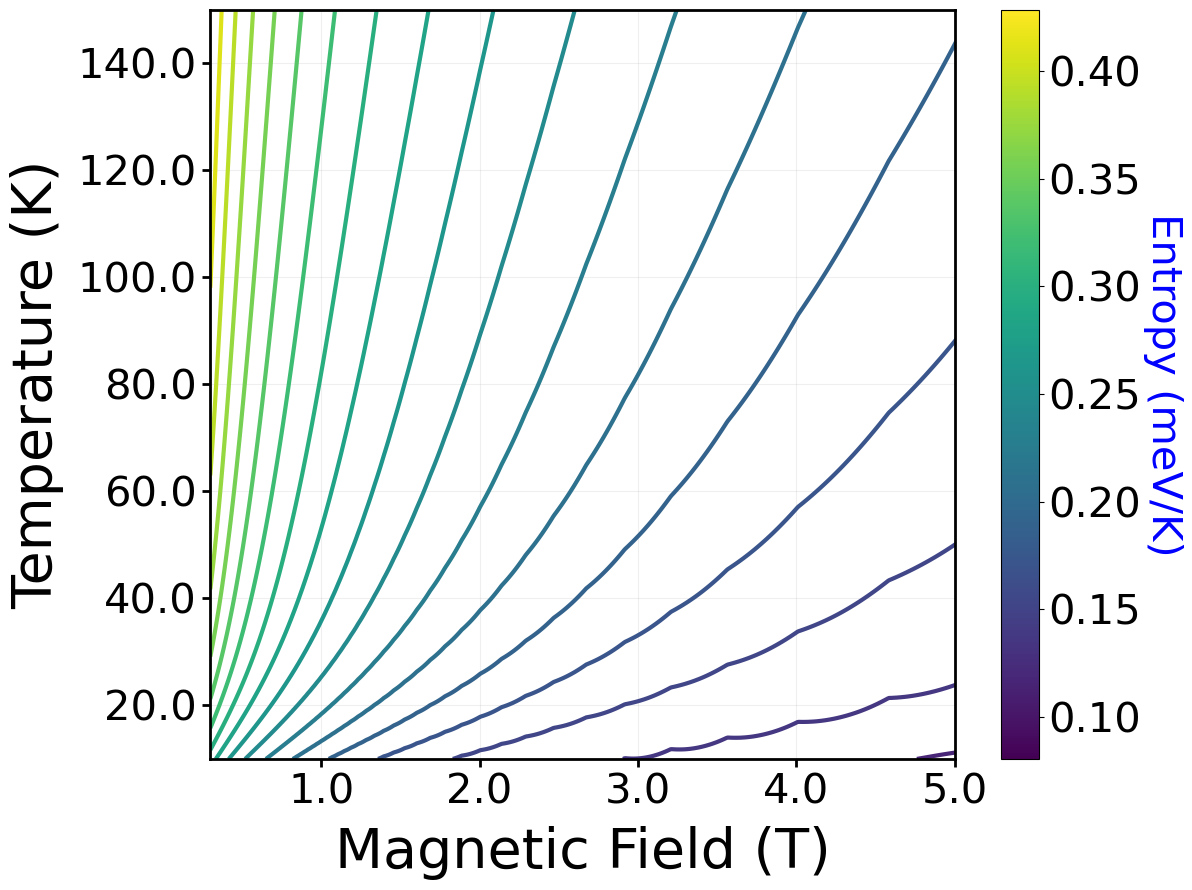

In [35]:
filename = "spectrum_B_1T_N1000_theta1.05_Ncon500_rc1000.npz"
data = np.load(filename)
B_vals = data["B_vals"]  # 1000 points from 0.3 to 8
spectra = data["spectra"]  # Energy spectra for each B value


T_vals = np.linspace(10, 150, 1000)


S_grid = np.zeros((len(T_vals), len(B_vals)))
for i, T in enumerate(T_vals):
    for j, B in enumerate(B_vals):
        E = spectra[j]  # Energy spectrum for this B value
        weights = np.exp(-E/(8.617e-5*T))
        prob = weights/np.sum(weights)
        S = -8.617e-5*np.sum(prob*np.log(prob + 1e-15))
        S_grid[i,j] = S*1000  # meV/K


S_min, S_max = np.min(S_grid), np.max(S_grid)
levels = np.linspace(S_min, S_max, 20)

plt.figure(figsize=(12,9))
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=30, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=30, width=1, length=4)
ax.grid(True, alpha=0.2)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

norm = colors.Normalize(vmin=S_min, vmax=S_max)
cmap = plt.colormaps['viridis']
contour = ax.contour(B_vals, T_vals, S_grid, levels=levels, cmap=cmap, linewidths=3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar
cbar = plt.colorbar(sm, ax=ax, format='%.2f')
cbar.set_label('Entropy (meV/K)', rotation=270, labelpad=30, fontsize=30, color='blue')

cbar.ax.tick_params(labelsize=30)
ax.set_xlabel('Magnetic Field (T)', fontsize=40, labelpad=10)
ax.set_ylabel('Temperature (K)', fontsize=40, labelpad=10)
ax.set_xlim(0.3, 5)
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

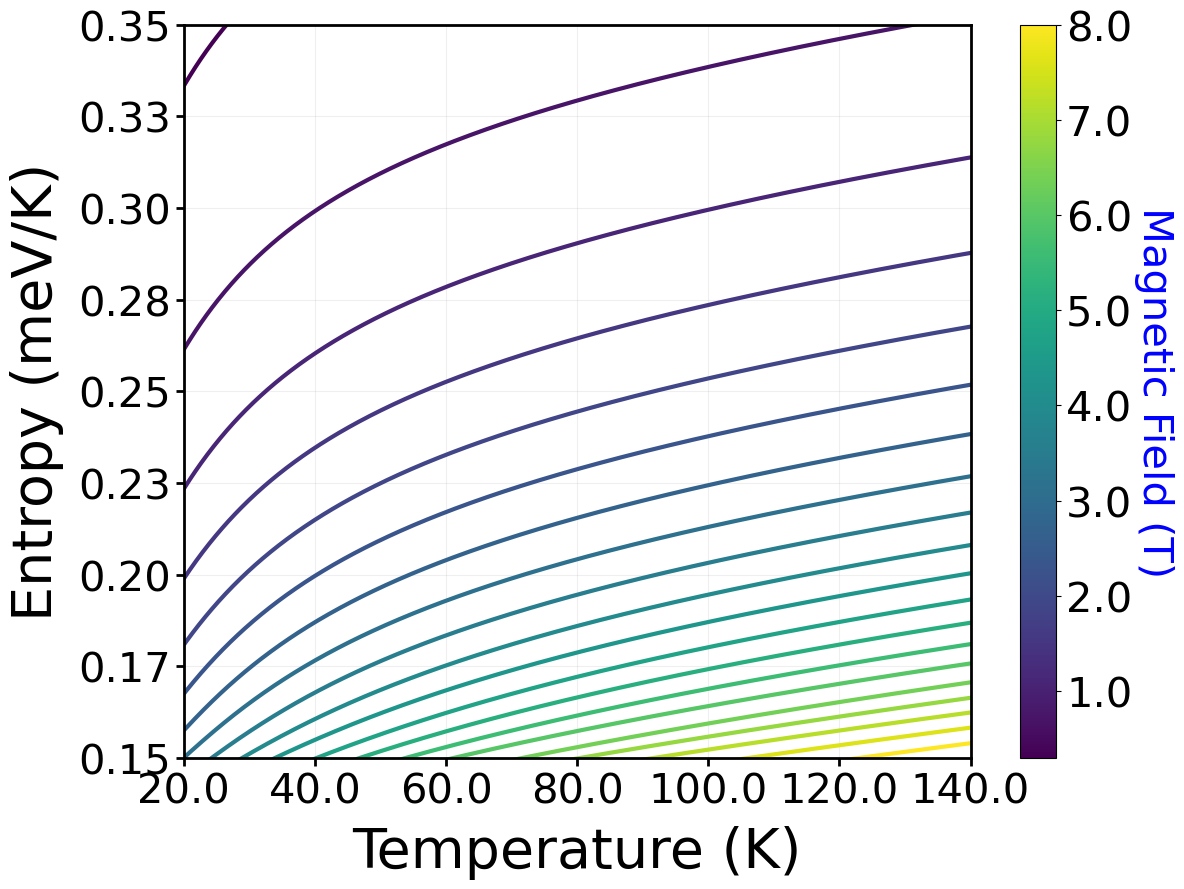

In [36]:
filename = "spectrum_B_1T_N1000_theta1.05_Ncon500_rc1000.npz"
data = np.load(filename)
B_vals = data["B_vals"]
spectra = data["spectra"]


T_vals = np.linspace(10, 150, 1000)


S_data = np.zeros((len(B_vals), len(T_vals)))
for i, B in enumerate(B_vals):
    E = spectra[i]
    for j, T in enumerate(T_vals):
        weights = np.exp(-E/(8.617e-5*T))
        prob = weights/np.sum(weights)
        S = -8.617e-5*np.sum(prob*np.log(prob + 1e-15))
        S_data[i,j] = S*1000  # meV/K


plt.figure(figsize=(12,9))
ax = plt.gca()

num_lines = 20
selected_B_indices = np.linspace(0, len(B_vals)-1, num_lines, dtype=int)
norm = colors.Normalize(vmin=B_vals.min(), vmax=B_vals.max())
cmap = plt.colormaps['viridis']  # Updated colormap access

for idx in selected_B_indices:
    ax.plot(T_vals, S_data[idx,:], 
            color=cmap(norm(B_vals[idx])),
            linewidth=3)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(B_vals)


cbar = plt.colorbar(sm, ax=ax, format='%.1f')
cbar.set_label('Magnetic Field (T)', rotation=270, labelpad=30, fontsize=30, color='blue')
cbar.ax.tick_params(labelsize=30)


ax.set_xlabel('Temperature (K)', fontsize=40, labelpad=10)
ax.set_ylabel('Entropy (meV/K)', fontsize=40, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=30, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=30, width=1, length=4)
ax.grid(True, alpha=0.2)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.xlim(20,140)
plt.ylim(0.15,0.35)
plt.show()